# HotMap

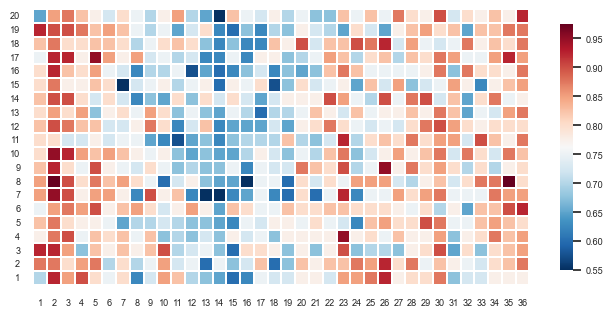

In [146]:
import sys

sys.path.append("/nfs-data/user30/Projects/adapter-gpt2")
import pickle
import torch
from utils.probs import _merge_heads, _split_heads
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

if "__main__" == __name__:
    parent_path = (
        "/nfs-data/user30/Projects/adapter-gpt2/data/paraDetox/att/gpt2-large/v8"
    )
    # "/nfs-data/user30/Projects/adapter-gpt2/data/paraDetox/att/gpt2-large/v8"
    # "/nfs-data/user30/Projects/adapter-gpt2/data/paraDetox/att/gpt2-large/analysis"
    head_path = parent_path + "/head-{count}.pkl".format(count=20)
    acc_path = parent_path + "/head_acc.pkl"
    all_head_wise_directions = pickle.load(
        open(
            head_path,
            "rb",
        )
    )  # torch.Size([36, 1280])
    # directions = _split_heads(all_head_wise_directions, num_heads=20, attn_head_size=64)
    acc = pickle.load(
        open(
            acc_path,
            "rb",
        )
    )  # [36,20]
    acc = acc.T
    # sns.set_context({"figure.figsize":(8,8)})
    sns.set(font_scale=0.6)
    heatmap = sns.heatmap(data=acc,vmin=0.55,cmap="RdBu_r",linewidths=0.3, xticklabels=range(1, len(acc[0]) + 1), yticklabels=range(1, len(acc) + 1), square=True, cbar_kws={"shrink": 0.4})
    plt.gca().invert_yaxis()
    #设置坐标字体方向
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
    plt.savefig("hotmap.pdf")
    plt.show()

# T-SNE

/tmp/ipykernel_52646/253448654.py:77: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[labels==i, 0], X_2d[labels==i, 1], marker=marker, label=f'Class {i}', color=colors[i], cmap="viridis")


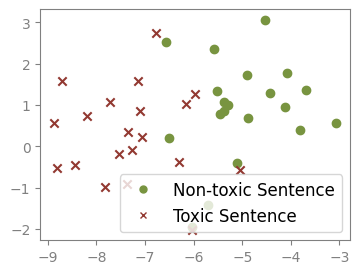

In [5]:
import sys

sys.path.append("/nfs-data/user30/Projects/adapter-gpt2")
import pickle
import torch
from utils.probs import _merge_heads, _split_heads
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

if "__main__" == __name__:
    parent_path = (
        "/nfs-data/user30/Projects/adapter-gpt2/data/paraDetox/att/gpt2-large/v8"
    )
    head_path = parent_path + "/head-{count}.pkl".format(count=20)
    acc_path = parent_path + "/head_acc.pkl"
    all_head_wise_directions = pickle.load(
        open(
            head_path,
            "rb",
        )
    )  # torch.Size([36, 1280])
    # directions = _split_heads(all_head_wise_directions, num_heads=20, attn_head_size=64)
    acc = pickle.load(
        open(
            acc_path,
            "rb",
        )
    )
    # print(directions.shape)
    # 23层第6个head (还可以); 12层第7个head (不好)
    layer = 23
    head = 6
    y_all = []
    n_all = []
    activations = pickle.load(
        open(
            "/nfs-data/user30/Projects/adapter-gpt2/data/paraDetox/att/gpt2-large/analysis/activations.pkl",
            "rb",
        )
    )
    # 遍历list，每个元素是一个turple，turple的两个元素都是list
    num_demonstration = len(activations)
    for demonstration_id in range(num_demonstration):
        y = torch.from_numpy(activations[demonstration_id][0])[:, layer-1, :].unsqueeze(0)
        n = torch.from_numpy(activations[demonstration_id][1])[:, layer-1, :].unsqueeze(
            0
        )  # torch.Size([1, 1, 1280])
        y = (_split_heads(y, num_heads=20, attn_head_size=64).squeeze(0).squeeze(1))[
            head-1, :
        ]  # torch.Size([1, 20, 1, 64])
        n = _split_heads(n, num_heads=20, attn_head_size=64).squeeze(0).squeeze(1)[head-1, :]

        y_all.append(y)
        n_all.append(n)

    y_stacked_tensor = torch.stack(y_all)
    y_numpy_matrix = y_stacked_tensor.numpy()
    n_stacked_tensor = torch.stack(n_all)
    n_numpy_matrix = n_stacked_tensor.numpy()
    # 合并两个矩阵
    X = np.vstack([y_numpy_matrix, n_numpy_matrix])
    labels = np.array([0] * len(y_numpy_matrix) + [1] * len(n_numpy_matrix))

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, perplexity=20, n_iter=5000, random_state=16)
    X_2d = tsne.fit_transform(X)

    # 绘制所有句子的2D表示
    markers = ['o', 'x']  # 自定义两个类别的图标
    colors = ['#789440', '#923931']  # 自定义两个类别的颜色
    plt.figure(figsize=(4, 3))
    # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="viridis")
    for i, marker in enumerate(markers):
        plt.scatter(X_2d[labels==i, 0], X_2d[labels==i, 1], marker=marker, label=f'Class {i}', color=colors[i], cmap="viridis")
    # plt.xlabel("t-SNE Component 1")
    # plt.ylabel("t-SNE Component 2")
    # 自定义图例旁边的文字
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    circle = mlines.Line2D([], [], color='#789440', marker='o', linestyle='None', markersize=5, label='Non-toxic Sentence')
    cross = mlines.Line2D([], [], color='#923931', marker='x', linestyle='None', markersize=5, label='Toxic Sentence')
    plt.legend(handles=[circle, cross], loc='best', fontsize='large')
    # 设置坐标轴颜色为灰色
    plt.tick_params(axis='x', colors='gray')
    plt.tick_params(axis='y', colors='gray')
    # 设置边框颜色为灰色
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('gray')
    # 保存为矢量图
    # plt.savefig("goodspace.svg", dpi=300,format="svg")
    plt.savefig("goodspace.pdf")
    plt.show()

# 控制强度

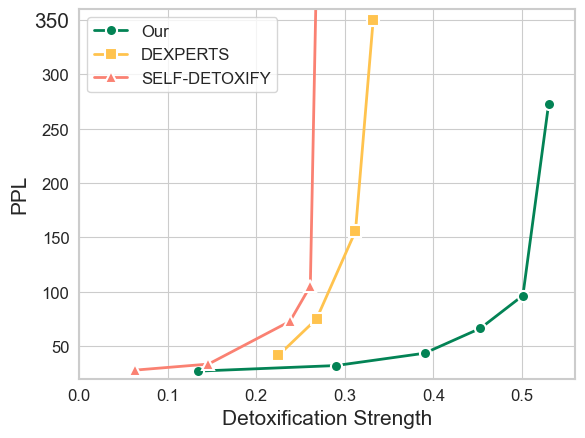

In [12]:
import sys

sys.path.append("/nfs-data/user30/Projects/adapter-gpt2")
import pickle
import torch
from utils.probs import _merge_heads, _split_heads
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ori = 0.560
our_y = [26.972,32.113,43.470,66.363,96.556, 272.406]
our_x = [ori-0.426,ori-0.270,ori-0.170,ori-0.107,ori-0.059, ori-0.030]
dexperts_y = [41.506, 74.958, 155.798, 350.348]
dexperts_x = [ori-0.335, ori-0.292,ori-0.248,ori-0.228]
reversal_nock_y = [27.901, 33.473, 72.817, 105.273, 522.691]
reversal_nock_x = [ori-0.497, ori-0.414,ori-0.322,ori-0.299, ori-0.289]
color1 = "#038355" # 孔雀绿
color2 = "#ffc34e" # 向日黄
color3 = "#FA8172"

# 设置字体
font = {'family' : 'Times New Roman',
        'size'   : 15}
plt.rc('font', **font)

# 绘图
sns.set_style("whitegrid") # 设置背景样式
sns.lineplot(x=our_x, y=our_y, color=color1, linewidth=2.0, marker="o", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='Our')
sns.lineplot(x=dexperts_x, y=dexperts_y, color=color2, linewidth=2.0, marker="s", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='DEXPERTS')
sns.lineplot(x=reversal_nock_x, y=reversal_nock_y, color=color3, linewidth=2.0, marker="^", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='SELF-DETOXIFY')

# 添加标题和标签
# plt.title("Trade-off between Detoxification Strength and PPL", fontweight='bold', fontsize=14)
plt.xlabel("Detoxification Strength", fontsize=15)
plt.ylabel("PPL", fontsize=15)

# 添加图例
plt.legend(loc='upper left', frameon=True, fontsize=12)

# 设置刻度字体和范围
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0.0, 0.560)
plt.ylim(20, 360)

# 设置坐标轴样式
for spine in plt.gca().spines.values():
    spine.set_edgecolor("#CCCCCC")
    spine.set_linewidth(1.5)

plt.savefig('lineplot.pdf')
# 显示图像
plt.show()